# SSAFY PyTorch project

본 과제에서는 딥러닝 분야의 연구에서 가장 많이 사용되는 PyTorch 프레임워크에 익숙해지는 것을 목표로 합니다. PyTorch를 이용하여 분류기 모델을 설계하고, CIFAR-10 데이터셋에 대하여 학습 및 테스트 코드를 작성할 예정입니다.

## Colab 사용시

실습 시작전에 `Runtime -> Change runtime type` 으로 이동하여 `Hardware Accelerator` 아래 `GPU`을 선택합니다. 해당 항목을 선택함으로 학습 시 GPU를 사용할 수 있습니다.

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation.

## PyTorch와 관련된 유용한 사이트

Justin Johnson 의 PyTorch [튜토리얼](https://github.com/jcjohnson/pytorch-examples).

PyTorch의 구체적인 기능을 담은 [API doc](http://pytorch.org/docs/stable/index.html).

API docs에서 해결되지 않는 질문들은 [PyTorch forum](https://discuss.pytorch.org/)을 참고.

# Table of Contents

본 실습은 총 5개의 파트로 구성되어 있습니다. 실습의 목적은 PyTorch의 3가지 다른 abstraction level을 학습하여 추후 있을 특화 프로젝트를 위해 PyTorch의 함수들에 익숙해지는 것입니다.

1. Part I, Preparation: 본 실습에서는 CIFAR-10 dataset을 사용합니다.
2. Part II, Barebones PyTorch: **Abstraction level 1**, 가장 low-level의 PyTorch 텐서를 활용해봅니다.
3. Part III, PyTorch Module API: **Abstraction level 2**, `nn.Module` 을 활용하여 임의의 딥러닝 모델을 정의합니다.
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, `nn.Sequential` 을 활용하여 선형 feed-forward 모델을 정의합니다.
5. Part V, CIFAR-10 open-ended challenge: 앞에서 습득한 것을 바탕으로 각자의 모델을 설계하여 CIFAR-10에서 높은 분류 정확도를 달성하는 것을 목표로 합니다. 모델 설계시 특정 레이어를 사용하거나, 학습시 optimizer를 변경하거나, hyperparameter를 튜닝하면서 성능을 높여 봅니다.


| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USE_GPU = True

dtype = torch.float32 # 본 실습에서 float을 사용

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 학습 시 학습 loss를 출력하는 빈도
print_every = 100

print('using device:', device)

using device: cuda


# Part I. Preparation

## 1. 데이터셋 준비 및 전처리
**본 과제에서는 데이터셋으로 CIFAR10을 사용합니다.**

CIFAR10은 3x32x32 크기의 이미지로 총 10개의 클래스(‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’) 로 구성된 60000장의 데이터셋입니다.

- ``torchvision``을 사용하여 CIFAR10 을 load 할 수 있습니다.
- ``torchvision.transform`` 을 사용하여 데이터를 normalize할 수 있습니다.

**references**\
dataloader(pytorch doc)\
https://pytorch.org/docs/stable/data.html

dataloader parameter(blog)\
https://subinium.github.io/pytorch-dataloader/


추가적으로 컴퓨터 비전 데이터를 다룰 때 ``torchvision``이라는 패키지를 사용하면 유용하고, 여러 데이터셋들을 다운 받을 수 있습니다.

In [3]:
# Req. 1-1	데이터셋 준비 및 전처리, 시각화
NUM_TRAIN = 49000

# torchvision.transforms 내에는 데이터 전처리 및 data augmentation을 위한 패키지를 제공
# 본 실습에서 [0,1] 범위의 데이터셋을 [-1, -1] 범위의 값으로 normalize하도록 transform 정의
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

# Dataset을 (train / val / test)으로 분리
# 분리된 Datasets를 DataLoader로 wrap하여, 추후 각 data들이 매 iteration마다 미니배치로 제공됨
cifar10_train = dset.CIFAR10('./cores/datasets/', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cores/datasets/', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cores/datasets/', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

# CIFAR10의 10개의 class 정의
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29566060.11it/s]


Extracting ./cores/datasets/cifar-10-python.tar.gz to ./cores/datasets/
Files already downloaded and verified
Files already downloaded and verified


### 데이터 시각화
- ``matplotlib``는 python visualization library
- ``matplotlib``의 imshow 함수를 데이터들을 시각화 할 수 있습니다.


**references**

matplotlib doc\
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html


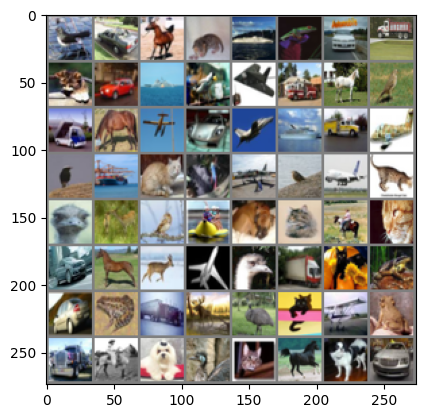

In [ ]:
# 이미지를 시각화하는 함수
def visualize(img):
    ################################################################################
    # TODO: 시각화를 위한 코드 작성.                                                    #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) [-1, -1] 범위로 normalize된 데이터를 [0,1] 범위로 unnormalize
    #normalize = (img - mean)/std
    #unnormalize = (norm_img * std) + mean

    img = (img * 0.5) + 0.5

    # 2) img를 numpy값으로 변환

    img = np.transpose(img,(1,2,0)) #(3,274,274) >> (274,274,3)으로 차원 바꿔야 시각화 가능
    img = img.numpy()

    # 3) plt.imshow함수로 시각화

    plt.imshow(img)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################


# 트레이닝 데이터를 랜덤 샘플
dataiter = iter(loader_train)
images, labels = next(dataiter) ## image

# show images
visualize(torchvision.utils.make_grid(images))

# Part II. Barebones PyTorch

PyTorch는 모델 아키텍처를 편리하게 정의할 수 있도록 high-level API와 함께 제공합니다. 본 파트에서는 high-level API를 다루기 전에 barebone PyTorch 부터 시작하여 autograd 엔진을 더 잘 이해할 수 있도록 합니다.

우리는 CIFAR-10 분류를 위해 두 개의 레이어와 ReLU로 구성된 간단한 fully-connected 네트워크로 시작합니다. 본 실습에서는 PyTorch Tensor의 연산을 사용하여 forward 패스를 계산하고 PyTorch autograd를 사용하여 backward 패스의 그레이디언트를 계산합니다.

`requires_grad=True`로 PyTorch Tensor를 생성하면 해당 텐서는 단순히 값을 계산하는 연산만 하는 것이 아니라 백그라운드에서 계산 그래프를 구축하여 loss와 관련된 텐서의 그레이디언트 계산합니다. 구체적으로, 만약 x가 `x.requires_grad == True`인 Tensor라면, 역전파 후 `x.grad`는 마지막에 스칼라 loss값과 관련하여 x의 그레디언트를 기록하는 또 다른 Tensor가 됩니다.

### PyTorch Tensors: Flatten 함수
PyTorch Tensor는 numpy array와 유사합니다. numpy와 마찬가지로 PyTorch에서도 효율적인 Tensor 연산을 위해 많은 함수들을 제공합니다. 간단한 예로, fully-connected 네트워크에 이미지 입력을 위하여 이미지 데이터를 reshape하는 `flatten` 함수를 제공합니다.

이미지 데이터는 일반적으로 N x C x H x W 형태의 Tensor로 저장됩니다. 여기서,

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the width of the intermediate feature map in pixels

위의 Tensor 형태의 경우, 2D 컨볼루션과 같은 공간적 이해를 필요로 하는 레이어를 적용할때 적절한 데이터 형태 입니다. 그러나 fully-connected 네트워크를 사용하여 이미지 데이터를 처리할 때 각 데이터가 단일 벡터로 표현되어야 합니다. 따라서 데이터 당 `C x H x W`값을 하나의 긴 벡터 형태로 변환해주기 위해 "flatten" 연산을 사용합니다. "flatten" 함수는 먼저 주어진 데이터 배치에서 N, C, H 및 W 값을 읽은 다음 해당 데이터의 "view"를 반환합니다. "view"는 numpy의 "reshape" 방법과 유사합니다.

In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Forward 패스를 수행하는 두개의 레이어를 가진 fully-connected ReLU 모델을 `two_layer_fc`의 이름으로 정의합니다. 정의한 이후 모델이 잘 동작하는지 확인하기 위해 zeros 값을 넣어봅니다. 본 실습에서는 별도로 코드를 작성하진 않지만, 구현된 코드를 자세히 읽어보고 다 이해하도록 합니다.  

In [ ]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    Fully-connected 네트워크는 다음과 같이 구성되어 있습니다:
    fully connected -> ReLU -> fully connected layer.
    위의 정의는 forward 패스만 구현한 것이고, backward 패스는 PyTorch가 자동으로 구현합니다.

    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).

    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # 먼저 이미지를 flatten 합니다.
    x = flatten(x)  # shape: [batch_size, C x H x W]

    w1, w2 = params

    # Forward 패스: Tensor에 정의된 operation을 활용하여 y값을 예측합니다.
    # w1과 w2는 requires_grad=True로 되어 있기 때문에 자동으로 계산 그래프를 구축하여
    # 자동으로 gradient값을 계산할 수 있습니다.
    # 따라서 수동으로 backward 패스를 구현하지 않아도 됩니다.

    #w1 = 첫번째 layer의 weight
    #w2 = 두번째 layer의 weight

    # x(input) > w1 > relu > w2 > output
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x


def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50

    # weight값 초기화
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype, requires_grad=True)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)

    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

Forward 패스를 수행하는 세개의 컨볼루션 레이어를 가진 모델을 `three_layer_convnet`의 이름으로 정의합니다. 앞선 실습과 마찬가지로 정의한 모델이 잘 동작하는 지 확인하기 위해 zero 값을 넣어봅니다. 네트워크 아키텍쳐는 다음과 같아야 합니다.

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

본 실습에서는 마지막 fully-connected layer 이후에 **softmax activation**이 없습니다. 이는 PyTorch의 cross entropy loss가 자동으로 softmax activation을 연산해주기 때문입니다.

**HINT**: For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [ ]:
# Req. 1-2	Three-Layer ConvNet 의 forward 패스 Tensor 연산으로 설계하기
def three_layer_convnet(x, params):
    """
    아래 정의된 모델은 3개의 컨볼루션 레이어를 갖는 네트워크의 forward 패스를 수행합니다.

    Inputs:
    - x: 이미지의 minibatch로 구성된 (N, 3, H, W) shape의 PyTorch 텐서
    - params: 네트워크의 weights와 biases를 담은 PyTorch 텐서의 리스트, 아래 내용들 포함
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer.
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer.

    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params

    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = F.conv2d(x,conv_w1,bias = conv_b1,padding = 2)
    x = F.relu(x)

    x = F.conv2d(x,conv_w2,bias = conv_b2, padding = 1)
    x = F.relu(x)

    x = flatten(x)

    scores = x.mm(fc_w) + fc_b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

Forward 패스에 해당하는 ConvNet을 정의한 이후 다음 cell을 실행하여 구현한 코드를 확인해봅니다.

다음 함수를 실행하면, (64,10) shape을 갖는 score값을 출력하게 됩니다.

In [ ]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype, requires_grad=True)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,), requires_grad=True)  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype, requires_grad=True)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,), requires_grad=True)  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10), requires_grad=True)
    fc_b = torch.zeros(10, requires_grad=True)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
몇가지 utility 메소드를 활용하여 모델의 weight matrices를 초기화해봅니다.

- `random_weight(shape)` 은 weight값을 Kaiming normalization method로 초기화 합니다.

- `zero_weight(shape)` 은 wieght값을 0으로 초기화 합니다.

`random_weight` 함수는 Kaiming normal initialization method로, 아래의 논문을 참고하면 됩니다:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [ ]:
def random_weight(shape):
    """
    Weight을 위한 랜덤 텐서를 생성합니다. 이때 requires_grad=True로 세팅해주어야
    추후에 backward 패스에서 사용할 gradient를 자동으로 계산할 수 있습니다.
    여기서 Kaiming normalization을 사용합니다: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))


tensor([[ 0.4800,  0.4918,  0.2536,  0.9073, -1.2810],
        [ 1.1050, -0.6456, -0.5893, -0.0575,  0.0649],
        [ 0.6306, -0.8428, -1.0596,  0.1927,  0.8757]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
모델을 학습할 때 다음의 함수를 활용하여 모델의 정확성을 확인합니다. 정확도를 확인할 때에는 gradient를 계산할 필요가 없습니다. 따라서 `torch.no_grad()`를 입력하여 계산 그래프의 gradient 계산을 막습니다.


In [ ]:
def check_accuracy_part2(loader, model_fn, params):
    """
    분류 모델의 정확성 측정

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model

    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad(): # gradient 계산할 필요가 없어, computational graph 를 그리지 않게 하기위해 with torch.no_grad() 사용
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
이제 학습 loop를 작성하여 네트워크를 학습합니다. 학습은 stochastic gradient descent를 사용합니다. 또한 `torch.functional.cross_entropy` 를 사용하여 loss를 측정합니다 [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

학습 loop는 네트워크 함수와 초기화된 weight 파라미터 (`[w1, w2]` in our example), 그리고 learning rate을 입력으로 받습니다.

In [ ]:
def train_part2(model_fn, params, learning_rate):
    """
    CIFAR-10에 대하여 모델 학습하기.

    Inputs:
    - model_fn: 모델의 forward 패스를 수행하는 PyTorch 함수.
      이는 이미지 데이터 x와 모델 weight의 list를 입력으로 받아 score를 출력하는 함수이다.
      scores = model_fn(x, params)
    - params: 모델 weight의 list
    - learning_rate: scalar 값

    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # 데이터를 적절한 device에 올리기
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward 패스를 수행하고, loss 계산하기
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward 패스 수행
        loss.backward()

        # 모델의 weight 업데이트하기. wieght 업데이트 시에는 gradient 계산은
        # torch.no_grad()를 사용하여 막는다
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Backward 패스를 마친 이후 수동으로 gradient 값을 0으로 초기화
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
이제 학습 loop 실행을 시작합니다. 먼저 앞서 정의한 weight 초기화 함수를 활용하여 `w1`와 `w2`를 정의합니다.

CIFAR-10의 각 미니배치의 Tensor shape은 `[64, 3, 32, 32]` 입니다.

이미지 데이터 `x`를 flatten한 뒤에 shape은 `[64, 3 * 32 * 32]`가 되어야 합니다. 이는 `w1`의 첫 dimension의 사이즈와 동일합니다. `w1`의 두번째 dimension의 사이즈는 hidden 레이어의 사이즈와 동일하고, 이는 동시에 `w2`의 첫 dimension의 사이즈와 동일합니다.

마지막으로, 네트워크의 출력은 10-dimensional vector이고, 이는 10개 클래스에 대한 확률을 나타냅니다.

별도로 hyperparameters를 수정하지 않고도 한 에폭 이후 40% 이상의 분류 정확도를 보이면 성공입니다.


In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3*32*32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

print('before training:')
print(w1)
train_part2(two_layer_fc, [w1, w2], learning_rate)
print()
print('after training:')
print(w1)

before training:
tensor([[-0.0035, -0.0067,  0.0310,  ...,  0.0100, -0.0355, -0.0280],
        [-0.0172,  0.0053, -0.0002,  ..., -0.0120, -0.0486, -0.0243],
        [-0.0213,  0.0087,  0.0394,  ..., -0.0099,  0.0473, -0.0273],
        ...,
        [ 0.0107, -0.0181,  0.0394,  ..., -0.0157,  0.0068,  0.0008],
        [ 0.0434,  0.0201,  0.0337,  ..., -0.0271,  0.0109,  0.0198],
        [-0.0127, -0.0120,  0.0138,  ...,  0.0286, -0.0118,  0.0029]],
       device='cuda:0', requires_grad=True)
Iteration 0, loss = 2.4169
Checking accuracy on the val set
Got 124 / 1000 correct (12.40%)

Iteration 100, loss = 2.0388
Checking accuracy on the val set
Got 352 / 1000 correct (35.20%)

Iteration 200, loss = 1.6540
Checking accuracy on the val set
Got 377 / 1000 correct (37.70%)

Iteration 300, loss = 1.6916
Checking accuracy on the val set
Got 390 / 1000 correct (39.00%)

Iteration 400, loss = 1.8315
Checking accuracy on the val set
Got 421 / 1000 correct (42.10%)

Iteration 500, loss = 1.6042
Che

### BareBones PyTorch: Training a ConvNet

Two-layer 네트워크 학습이 마쳤다면, 여기에서는 ConvNet을 학습시켜 봅니다. 여기서 정의해야할 네트워크는 다음과 같은 구조를 가져야 합니다.

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

모든 weight matrices는 앞서 정의한 `random_weight` 함수를 사용하여 초기화 시켜 주어야 하고, bias vector는 `zero_weight` 함수로 초기화 시켜 줍니다.

별도로 hyperparameters를 수정하지 않고도 한 에폭 이후 42% 이상의 분류 정확도를 보이면 성공입니다.

In [ ]:
# Req. 1-3	Three-Layer ConvNet의 weight 파라미터를 Tensor 형태로 초기화

learning_rate = 3e-3

channel_1 = 32
channel_2 = 16


################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

conv_w1 = random_weight((channel_1,3,5,5))
conv_b1 = zero_weight((channel_1,))
conv_w2 = random_weight((channel_2,channel_1,3,3))
conv_b2 = zero_weight((channel_2,))
fc_w = random_weight((channel_2*32*32,10))
fc_b = zero_weight((10,))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.5917
Checking accuracy on the val set
Got 121 / 1000 correct (12.10%)

Iteration 100, loss = 2.0804
Checking accuracy on the val set
Got 284 / 1000 correct (28.40%)

Iteration 200, loss = 1.9964
Checking accuracy on the val set
Got 360 / 1000 correct (36.00%)

Iteration 300, loss = 1.8515
Checking accuracy on the val set
Got 398 / 1000 correct (39.80%)

Iteration 400, loss = 1.7609
Checking accuracy on the val set
Got 425 / 1000 correct (42.50%)

Iteration 500, loss = 1.9501
Checking accuracy on the val set
Got 434 / 1000 correct (43.40%)

Iteration 600, loss = 1.6536
Checking accuracy on the val set
Got 443 / 1000 correct (44.30%)

Iteration 700, loss = 1.7736
Checking accuracy on the val set
Got 430 / 1000 correct (43.00%)



# Part III. PyTorch Module API

Barebone PyTorch에서는 모든 파라미터 텐서들을 직접 관리했습니다. 작은 네트워크일 경우일때는 괜찮지만, 네트워크가 커질수록 직접 파라미터 하나하나 정의하고 관리하기에는 불가능합니다.

PyTorch는 `nn.Module` API를 제공하여 직접 임의의 네트워크를 정의할 수 있고 학습 가능한 파라미터를 자동으로 추적할 수 있게 도와줍니다. Part II에서는 SGD를 직접 구현했지만 PyTorch는 `torch.optim` 패키지를 제공하여 SGD와 더불어 다양한 optimizer를 사용할수 있게 합니다. 다음의 자료 [doc](http://pytorch.org/docs/master/optim.html)를 참고하여 다양한 optimizer의 정의를 살펴보길 바랍니다.

Module API를 사용하기 위해서 아래의 step을 따라야 합니다:

1. Subclass `nn.Module`. `nn.Module`를 상속받아 `TwoLayerFC`와 같은 직관적인 이름으로 네트워크 클래스 정의.

2. 정의한 클래스의 `__init__()`에서 모델을 구성하는 모든 레이어에 대해서 정의합니다. `nn.Linear`와 `nn.Conv2d`는 `nn.Module`의 subclasses로 학습 가능한 파라미터를 포함하고 있어 별도로 Tensor를 초기화하지 않아도 됩니다. 다양한 builtin 레이어들에 대해 공부하고 싶다면 다음 자료 [doc](http://pytorch.org/docs/master/nn.html)를 참고시길 바랍니다. **Warning**: 클래스 정의시 `super().__init__()`를 가장 먼저 호출합니다.

3. `forward()` method에서는 네트워크 내 레이어들의 연결들을 정의해주어야 합니다. 앞선 `__init__`에서 정의한 레이어들을 입력과 출력 shape에 맞는 레이어들로 연결해줍니다. `forward()`에서는 새로운 학습 가능한 파라미터를 생성하면 안됩니다. 모든 파라미터 생성은 `__init__`에서 만들어져야 합니다.


### Module API: Two-Layer Network
아래는 2개의 레이어를 갖는 fully-connected 네트워크의 구체적인 예시입니다.

In [ ]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # 레이어 2개를 정의합니다.
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        # nn.init 패키지 내에서 초기화 함수를 사용합니다.
        # http://pytorch.org/docs/master/nn.html#torch-nn-init
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # forward 에서는 레이어의 연결을 정의합니다.
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet
이제 여기서는 3개의 컨볼루션 레이어와 fully-connected 레이어를 갖는 ConvNet를 직접 구현해 봅니다. 네트워크의 구조는 Part II에서 정의한 것과 동일합니다:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

Kaiming normal initialization method를 활용하여 정의한 레이어들을 초기화 합니다.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

ConvNet를 구현한 이후, `test_ThreeLayerConvNet` 함수를 실행하면`(64, 10)` shape 의 output score를 출력하게 됩니다.

### Pytorch functions
- ``nn.Conv2d`` : torch.nn.Conv2d(in_channels: int, out_channels: int, kernel_size, stride = 1, padding = 0)
- ``nn.Maxpool2d`` : torch.nn.MaxPool2d(kernel_size, stride = None, padding = 0)
- ``nn.Linear`` : torch.nn.Linear(in_features: int, out_features: int, bias: bool = True)


**references**

https://tutorials.pytorch.kr/beginner/examples_nn/two_layer_net_module.html

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html


**tips**

http://taewan.kim/post/cnn/

http://taewan.kim/post/cnn/#4-cnn-%EC%9E%85%EC%B6%9C%EB%A0%A5-%ED%8C%8C%EB%A6%AC%EB%AF%B8%ED%84%B0-%EA%B3%84%EC%82%B0

https://mrsyee.github.io/image%20processing/2018/11/28/cnn_technique/


In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [ ]:
# Req. 1-4	Three-Layer ConvNet 클래스를 Module API를 활용하여 정의하기

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.conv1 = nn.Conv2d(in_channels = in_channel, out_channels = channel_1, kernel_size = 5, padding = 2)
        self.conv2 = nn.Conv2d(in_channels = channel_1, out_channels = channel_2, kernel_size = 3, padding = 1)
        self.fc = nn.Linear(channel_2*32*32,num_classes)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))

        scores = flatten(x)

        scores = self.fc(scores)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Validation이나 test set이 주어졌을 때 분류 정확도를 측정합니다.

해당 버전은 수동으로 파라미터를 전달했던 part II와는 약간 다릅니다.

In [5]:
# Req. 1-5	Module API에서 성능 평가 함수 구현하기

def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode

    ########################################################################
    # TODO: Implement the function for evaluating the accuracy of the model#
    ########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    with torch.no_grad():

        for images, labels in loader:

            images = images.to(device)
            labels = labels.to(device)

            scores = model(images)

            _, preds = scores.max(1)

            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)

        acc = num_correct / num_samples

        print(f'Got {num_correct}/{num_samples} correct {100*acc:.2f}%')

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

### Module API: Training Loop

학습 loop를 작성합니다. 직접 파라미터를 업데이트하기 위한 코드를 작성하지 않고, `torch.optim` 패키지 내의 optimizer를 사용하여 자동으로 파라미터를 업데이트 해줍니다.

In [6]:
# Req. 1-6	Module API에서 학습 loop 구현하기

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    ########################################################################
    # TODO: Implement the training loop                                    #
    ########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) 첫번째 for문으로 epochs 만큼 반복
    for epoch in range(epochs):

    # 2) 두번째 for문으로 trainset이 저장되어 있는 loader_train에서 배치 사이즈 만큼씩 data load
        for t,(images, labels) in enumerate(loader_train):

    # 3) load한 data에서 input 값과 label을 device에 올림 (GPU or CPU)

            images = images.to(device)
            labels = labels.to(device)

    # 4) model에 input값을 입력하여 forward 패스 수행

            scores = model(images)

    # 5) loss function으로 예측값과 label 비교
            loss = F.cross_entropy(scores,labels)

    # 6) optimizer에서 gradient 값 0으로 초기화
            optimizer.zero_grad()

    # 7) loss 값 backpropagation 하여 gradient 계산
            loss.backward()

    # 8) Optimizer 업데이트
            optimizer.step()

    # 9) loss와 accuracy를 print_every 주기 마다 출력
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_train, model)
                model.train()
                print()

    # 10) 2)로 돌아가 반복 한뒤 2)가 모두 마치면 1)로 돌아가 반복

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

### Module API: Train a Two-Layer Network
이제 학습 loop 실행을 시작합니다. Part II와 다르게 파라미터를 직접 정의하지 않아도 됩니다.

Input size, hidden 레이어 size, output size(클래스 개수)를 입력하여 `TwoLayerFC`의 객체를 생성합니다.

또한 `TwoLayerFC`의 학습 가능한 파라미터를 추적하기 위한 optimizer 또한 정의합니다.

별도로 hyperparameters를 수정하지 않고도 한 에폭 이후 40% 이상의 분류 정확도를 보이면 성공입니다.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 2.4630
Checking accuracy on validation set
Got 6541/49000 correct 0.13%

Iteration 100, loss = 1.7969
Checking accuracy on validation set
Got 17587/49000 correct 0.36%

Iteration 200, loss = 1.5984
Checking accuracy on validation set
Got 19607/49000 correct 0.40%

Iteration 300, loss = 1.7804
Checking accuracy on validation set
Got 20220/49000 correct 0.41%

Iteration 400, loss = 1.8755
Checking accuracy on validation set
Got 21024/49000 correct 0.43%

Iteration 500, loss = 1.8588
Checking accuracy on validation set
Got 22207/49000 correct 0.45%

Iteration 600, loss = 1.6120
Checking accuracy on validation set
Got 21809/49000 correct 0.45%

Iteration 700, loss = 1.5423
Checking accuracy on validation set
Got 22661/49000 correct 0.46%



### Module API: Train a Three-Layer ConvNet
이제 Module API를 사용하여 직접 three-layer ConvNet을 설계합니다. 앞선 two-layer 네트워크와 비슷할 것 입니다. 별도로 hyperparameters를 수정하지 않고도 한 에폭 이후 40% 이상의 분류 정확도를 보이면 성공입니다. 모델 학습 시 stochastic gradient descent를 사용합니다.

In [ ]:
# Req. 1-7	ThreeLayerConvNet의 instance만들고 optimizer 정의

learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = ThreeLayerConvNet(3,channel_1,channel_2,10)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 2.4839
Checking accuracy on validation set
Got 5146/49000 correct 10.50%

Iteration 100, loss = 1.9598
Checking accuracy on validation set
Got 15308/49000 correct 31.24%

Iteration 200, loss = 1.8346
Checking accuracy on validation set
Got 17723/49000 correct 36.17%

Iteration 300, loss = 1.7301
Checking accuracy on validation set
Got 19274/49000 correct 39.33%

Iteration 400, loss = 1.6705
Checking accuracy on validation set
Got 20091/49000 correct 41.00%

Iteration 500, loss = 1.8957
Checking accuracy on validation set
Got 20499/49000 correct 41.83%

Iteration 600, loss = 1.5347
Checking accuracy on validation set
Got 21040/49000 correct 42.94%

Iteration 700, loss = 1.9097
Checking accuracy on validation set
Got 21755/49000 correct 44.40%



# Part IV. PyTorch Sequential API

Feed forward layers가 여러개 쌓여져 있는 간단한 모델의 경우에도 다음과 같이 3가지 step을 따라야 합니다: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. 본 파트에서는 이보다 더 간단한 방법을 제공합니다.

PyTorch 는 `nn.Sequential`라는 container Module을 제공하고, 이는 위의 3가지 step을 하나로 합쳐 줍니다.

### Sequential API: Two-Layer Network
먼저 `nn.Sequential`를 사용하여 two-layer 네트워크를 다시 정의하고, 앞서 정의한 학습 loop로 학습시켜 봅니다.

별도로 hyperparameters를 수정하지 않고도 한 에폭 이후 40% 이상의 분류 정확도를 보이면 성공입니다.

In [ ]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.2980
Checking accuracy on validation set
Got 7382/49000 correct 15.07%

Iteration 100, loss = 1.8146
Checking accuracy on validation set
Got 19277/49000 correct 39.34%

Iteration 200, loss = 1.5793
Checking accuracy on validation set
Got 21298/49000 correct 43.47%

Iteration 300, loss = 1.6956
Checking accuracy on validation set
Got 22692/49000 correct 46.31%

Iteration 400, loss = 1.5798
Checking accuracy on validation set
Got 23408/49000 correct 47.77%

Iteration 500, loss = 1.5547
Checking accuracy on validation set
Got 24357/49000 correct 49.71%

Iteration 600, loss = 1.6139
Checking accuracy on validation set
Got 24732/49000 correct 50.47%

Iteration 700, loss = 1.5231
Checking accuracy on validation set
Got 25428/49000 correct 51.89%



### Sequential API: Three-Layer ConvNet
이제 `nn.Sequential`를 활용하여 Part III와 동일한 구조의 three-layer ConvNet를 직접 정의하고 학습시켜 봅니다:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

Weight matrices는 앞서 정의한 `random_weight` 함수로 초기화 하고 bias vectors `zero_weight` 함수로 초기화 합니다.

Optimizer로는 Nesterov momentum 0.9를 갖는 stochastic gradient descent를 사용합니다.

별도로 hyperparameters를 수정하지 않고도 한 에폭 이후 55% 이상의 분류 정확도를 보이면 성공입니다.

In [ ]:
def random_weight(shape):
    """
    Weight을 위한 랜덤 텐서를 생성합니다. 이때 requires_grad=True로 세팅해주어야
    추후에 backward 패스에서 사용할 gradient를 자동으로 계산할 수 있습니다.
    여기서 Kaiming normalization을 사용합니다: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[1] #nn.Linear의 weight shape와 맞추기 (out_feature, in_feature)
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

In [ ]:
# Req. 1-8	ThreeLayerConvNet을 Sequential API로 구현하기

channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

conv1 = nn.Conv2d(3,channel_1,kernel_size = 5, padding = 2)
conv1.weight.data = random_weight((channel_1,3,5,5))
conv1.bias.data = zero_weight((channel_1,))

conv2 = nn.Conv2d(channel_1,channel_2, kernel_size = 3, padding = 1)
conv2.weight.data = random_weight((channel_2,channel_1,3,3))
conv2.bias.data = zero_weight((channel_2,))

fc = nn.Linear(channel_2*32*32, 10)
fc.weight.data = random_weight((10,channel_2*32*32))
fc.bias.data = zero_weight((10,))

model = nn.Sequential(
    conv1,
    nn.ReLU(),
    conv2,
    nn.ReLU(),
    Flatten(),
    fc
)

optimizer = optim.SGD(model.parameters(), lr = learning_rate,
                      momentum = 0.9, nesterov = True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 2.3716
Checking accuracy on validation set
Got 7359/49000 correct 15.02%

Iteration 100, loss = 1.4048
Checking accuracy on validation set
Got 21306/49000 correct 43.48%

Iteration 200, loss = 1.5191
Checking accuracy on validation set
Got 24220/49000 correct 49.43%

Iteration 300, loss = 1.4279
Checking accuracy on validation set
Got 25346/49000 correct 51.73%

Iteration 400, loss = 1.4295
Checking accuracy on validation set
Got 26412/49000 correct 53.90%

Iteration 500, loss = 1.2633
Checking accuracy on validation set
Got 26822/49000 correct 54.74%

Iteration 600, loss = 1.3338
Checking accuracy on validation set
Got 28250/49000 correct 57.65%

Iteration 700, loss = 1.3803
Checking accuracy on validation set
Got 28920/49000 correct 59.02%



# Part V. CIFAR-10 open-ended challenge

본 파트에서는 자유롭게 ConvNet을 설계하여 CIFAR-10을 학습시켜 높은 분류 정확도를 달성하는 것을 목표로 합니다.

여기에서는 모델 아키텍쳐, hyperparameter, loss function, optimizer 등을 다양하게 바꿔가며 실험하면서 모델을 학습시켜 CIFAR-10에 대하여 10개의 epoch내에서 validation set의 **최소 70% 이상**의 정확도를 달성합니다. 실험시 앞에서 학습했던 `nn.Module` 혹은 `nn.Sequential` API을 활용합니다.

참고자료:
* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### 시도할 수 있는 것:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Going above and beyond
- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [51]:
class ConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, channel_3, num_classes):
        super().__init__()

        self.batch_norm1 = nn.BatchNorm2d(in_channel)
        self.conv1 = nn.Conv2d(in_channels = in_channel, out_channels = channel_1, kernel_size = 5,padding = 2)

        self.batch_norm2 = nn.BatchNorm2d(channel_1)
        self.conv2 = nn.Conv2d(in_channels = channel_1, out_channels = channel_2, kernel_size = 3,padding = 1)

        self.batch_norm3 = nn.BatchNorm2d(channel_2)
        self.conv3 = nn.Conv2d(in_channels = channel_2, out_channels = channel_3, kernel_size = 1)

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(channel_3*32*32,num_classes)

    def forward(self, x):

        x = self.conv1(F.relu(self.batch_norm1(x)))

        x = self.conv2(F.relu(self.batch_norm2(x)))

        x = self.conv3(F.relu(self.batch_norm3(x)))

        x = self.dropout(x)

        scores = flatten(x)

        scores = self.fc(scores)

        return scores

In [48]:
model = ConvNet(3,32,16,8,10)

model(torch.randn((1,3,32,32)))

tensor([[ 0.2076, -0.0452, -0.0281, -0.0102, -0.1397, -0.3330, -0.0397, -0.3860,
          0.1931,  0.1442]], grad_fn=<AddmmBackward0>)

In [53]:
# Req. 1-9	다양한 실험을 통해 성능 끌어 올리기

################################################################################
# TODO:                                                                        #
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = ConvNet(3,32,16,8,10)
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr = learning_rate,
                      momentum = 0.9, nesterov = True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=10)

Iteration 0, loss = 2.3650
Checking accuracy on validation set
Got 4862/49000 correct 9.92%

Iteration 100, loss = 1.9675
Checking accuracy on validation set
Got 17942/49000 correct 36.62%

Iteration 200, loss = 1.8826
Checking accuracy on validation set
Got 20447/49000 correct 41.73%

Iteration 300, loss = 1.4532
Checking accuracy on validation set
Got 22466/49000 correct 45.85%

Iteration 400, loss = 1.6353
Checking accuracy on validation set
Got 22143/49000 correct 45.19%

Iteration 500, loss = 1.5154
Checking accuracy on validation set
Got 24053/49000 correct 49.09%

Iteration 600, loss = 1.7507
Checking accuracy on validation set
Got 24434/49000 correct 49.87%

Iteration 700, loss = 1.4597
Checking accuracy on validation set
Got 25449/49000 correct 51.94%

Iteration 0, loss = 1.4696
Checking accuracy on validation set
Got 25382/49000 correct 51.80%

Iteration 100, loss = 1.1412
Checking accuracy on validation set
Got 25863/49000 correct 52.78%

Iteration 200, loss = 1.2628
Checkin

## Test set -- run this only once

Validation에서 만족스러운 성능을 얻었다면, 마지막으로 test set에 대해서 학습된 모델을 평가해 봅니다.

In [54]:
best_model = model
check_accuracy_part34(loader_test, model)

Checking accuracy on test set
Got 6418/10000 correct 64.18%


In [55]:
print('# parameters : ', sum(p.numel() for p in best_model.parameters() if p.requires_grad))

# parameters :  89224
